# Initials

In [2]:
pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install torchhk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchhk import transform_model

import torchbnn as bnn
import matplotlib.pyplot as plt
import numpy as np

# Load dataset

In [5]:
cuda2 = torch.cuda.is_available() 
batch_size2 = 128
log_interval2 = 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size2, shuffle=True, **kwargs)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

def evaluate(model):
    model.eval()
    mse = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, _, _ = model(data)           
            mse += torch.sum(torch.square(data.view([-1, 784]) - recon_batch.view([-1, 784])))            
    mse = mse / len(test_loader.dataset)
    return mse


# Basic VAE

### Define network

In [14]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, latent_dim) # 20 -> 2
        self.fc22 = nn.Linear(100, latent_dim) # 20 -> 2
        self.fc3 = nn.Linear(latent_dim, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return torch.distributions.normal.Normal(loc = self.fc21(h2), scale = torch.exp(0.5*self.fc22(h2)))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x): # model(data) = model.forward(data)
        gauss = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    train_losses.append(train_loss / len(train_loader.dataset))


def test(epoch, loader):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

### Train

====> Epoch: 1 Average loss: 189.3819
====> Test set loss: 164.6404


<ipython-input-15-cb057d2aa1d7>:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


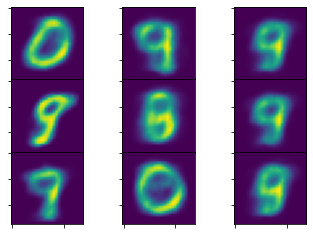

====> Epoch: 2 Average loss: 160.7145
====> Test set loss: 156.3969


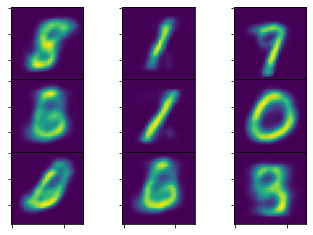

====> Epoch: 3 Average loss: 154.1982
====> Test set loss: 151.5191


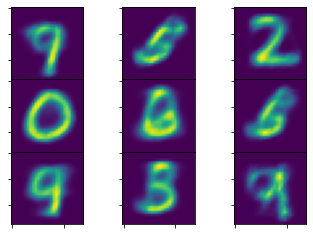

====> Epoch: 4 Average loss: 150.3582
====> Test set loss: 148.5930


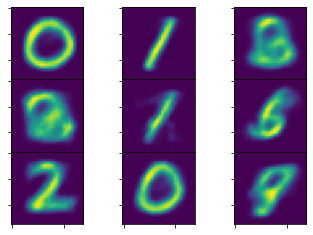

====> Epoch: 5 Average loss: 147.9108
====> Test set loss: 146.7408


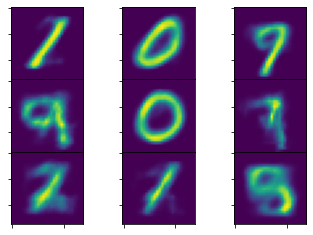

====> Epoch: 6 Average loss: 145.9466
====> Test set loss: 145.0816


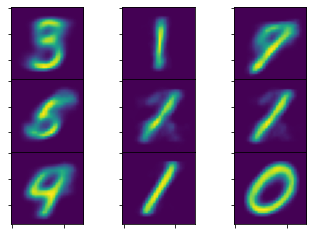

====> Epoch: 7 Average loss: 144.6178
====> Test set loss: 144.3876


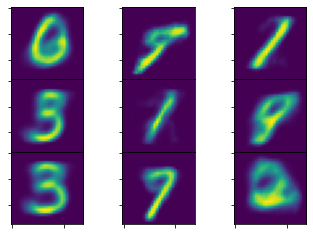

====> Epoch: 8 Average loss: 143.3397
====> Test set loss: 143.0010


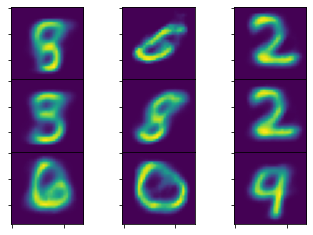

====> Epoch: 9 Average loss: 142.1251
====> Test set loss: 141.7382


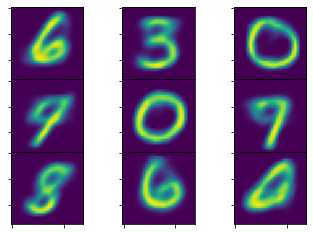

====> Epoch: 10 Average loss: 141.2153
====> Test set loss: 140.9302


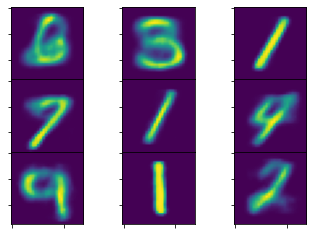

In [15]:
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs2 = 10 # 10

train_losses = []
val_losses = []
for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch, validation_loader)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        # plt.imshow(sample[0].reshape([28,28]))
        fig, ax = plt.subplots(3,3,constrained_layout=True)
        plt.subplots_adjust(wspace=0, hspace=0)
        for i, ax in enumerate(ax.flatten()):
            ax.imshow(sample[i].reshape([28,28]))
            plt.axis('on')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.show()

### Plot original and reconstructed

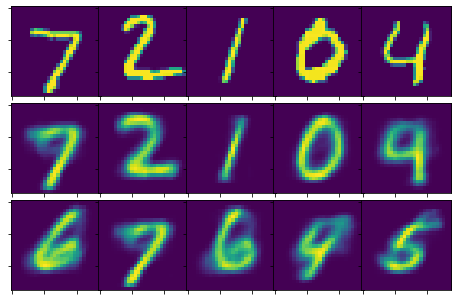

In [16]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(nrows=3, ncols=5, sharex = True, sharey = True)
    for j in range(5):
      for i in range(2):
          ax[i,j].set_xticklabels([])
          ax[i,j].set_yticklabels([])
    sample = sample_image
    for j in range(5):
      ax[0,j].imshow(sample[j].reshape([28,28]))
    sample = model(sample_image)[0]
    for j in range(5):
      ax[1,j].imshow(sample[j].reshape([28,28]))
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    for j in range(5):
     ax[2,j].imshow(sample[j].reshape([28,28]))
          
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis('on')
plt.show()

<ipython-input-129-5b43f76ec2be>:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


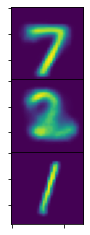

<ipython-input-129-5b43f76ec2be>:26: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


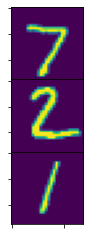

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    sample = model(sample_image)[0]
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()
    sample =sample_image
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

<ipython-input-130-73106014c787>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


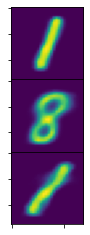

In [ ]:
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    # save_image(sample.view(64, 1, 28, 28),
    #            'results/sample_' + str(epoch) + '.png')
    # plt.imshow(sample[0].reshape([28,28]))
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

### Plot losses

Text(0, 0.5, 'Loss')

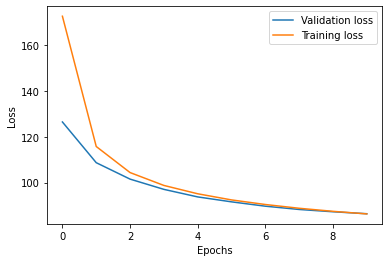

In [ ]:
plt.plot([*range(epochs2)], val_losses, label="Validation loss")
plt.plot([*range(epochs2)], train_losses, label = "Training loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Find expected value in latent space for each number

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat).mean
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

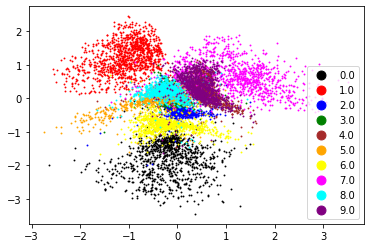

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

In [ ]:
evaluate(model)

tensor(11.8907)

# Convolutional VAE

### Define network

In [17]:
class VAEconv(nn.Module):
    def __init__(self, latent_dim):
        super(VAEconv, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64*4*4, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3a = nn.Linear(100, latent_dim)
        self.fc3b = nn.Linear(100, latent_dim)

        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
        self.fc4 = nn.Linear(latent_dim, 64*4*4)
        self.fc5 = nn.Linear(64*4*4, 64*4*4)
        self.fc6 = nn.Linear(64*4*4, 64*4*4)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.distributions.normal.Normal(loc = self.fc3a(x), 
                                                 scale = torch.max(torch.exp(0.5*self.fc3b(x)),torch.tensor(1e-4)))

    def decode(self, z):
        x = F.relu(self.fc4(z))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = x.view(-1, 64, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.sigmoid(self.deconv3(x))
        return x

    def forward(self, x):
        # mu, logvar = self.encode(x)
        # z = self.reparameterize(mu, logvar)
        # return self.decode(z), mu, logvar

        gauss = self.encode(x)
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch, losses):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    losses.append(train_loss / len(train_loader.dataset))


def test(epoch, losses, loader):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    losses.append(test_loss)

### Train

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


====> Epoch: 1 Average loss: 200.5619
====> Test set loss: 155.3289


<ipython-input-18-3d17dfc1ce99>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


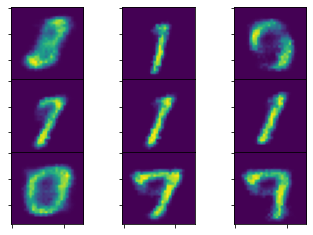

====> Epoch: 2 Average loss: 135.5719
====> Test set loss: 121.3412


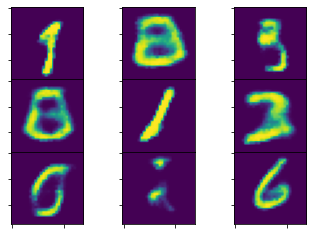

====> Epoch: 3 Average loss: 111.5130
====> Test set loss: 105.3525


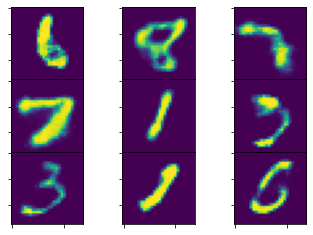

====> Epoch: 4 Average loss: 101.3024
====> Test set loss: 97.8594


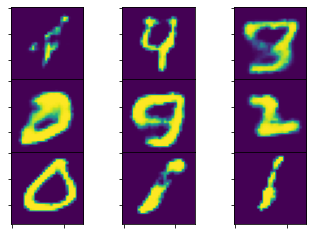

====> Epoch: 5 Average loss: 95.1688
====> Test set loss: 92.8965


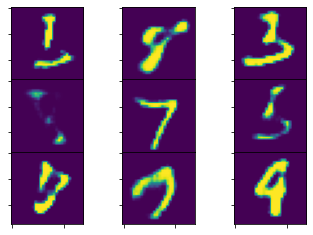

====> Epoch: 6 Average loss: 90.1261
====> Test set loss: 88.5425


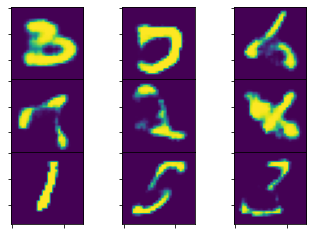

====> Epoch: 7 Average loss: 87.1232
====> Test set loss: 86.0938


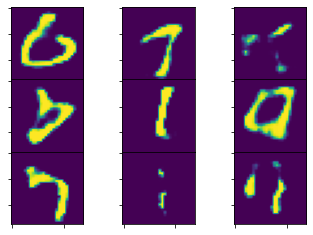

====> Epoch: 8 Average loss: 85.2435
====> Test set loss: 84.6708


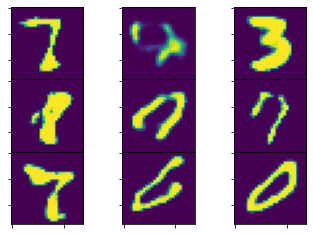

====> Epoch: 9 Average loss: 83.6921
====> Test set loss: 83.5180


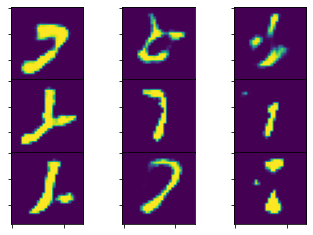

====> Epoch: 10 Average loss: 82.6132
====> Test set loss: 82.8104


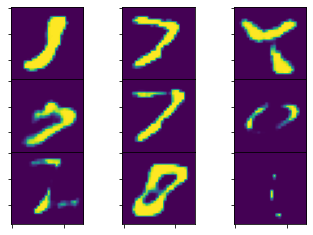

In [18]:
latent_dim = 10
model = VAEconv(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs2 = 10 # 10
train_losses = []
val_losses = []
for epoch in range(1, epochs2 + 1):
    train(epoch, train_losses)
    test(epoch, val_losses, validation_loader)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        # plt.imshow(sample[0].reshape([28,28]))
        fig, ax = plt.subplots(3,3,constrained_layout=True)
        plt.subplots_adjust(wspace=0, hspace=0)
        for i, ax in enumerate(ax.flatten()):
            ax.imshow(sample[i].reshape([28,28]))
            plt.axis('on')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.show()

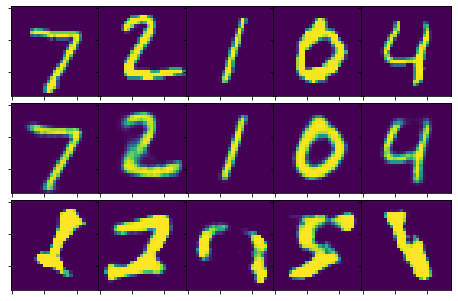

In [19]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(nrows=3, ncols=5, sharex = True, sharey = True)
    for j in range(5):
      for i in range(2):
          ax[i,j].set_xticklabels([])
          ax[i,j].set_yticklabels([])
    sample = sample_image
    for j in range(5):
      ax[0,j].imshow(sample[j].reshape([28,28]))
    sample = model(sample_image)[0]
    for j in range(5):
      ax[1,j].imshow(sample[j].reshape([28,28]))
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    for j in range(5):
     ax[2,j].imshow(sample[j].reshape([28,28]))
          
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis('on')
plt.show()

<ipython-input-153-b8f7f1a1f3c6>:11: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


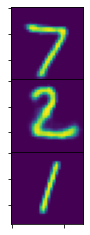

<ipython-input-153-b8f7f1a1f3c6>:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


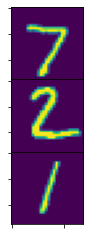

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    sample = model(sample_image)[0]
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()
    sample =sample_image
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

<ipython-input-157-73106014c787>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


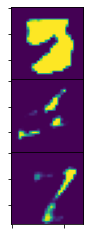

In [ ]:
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    # save_image(sample.view(64, 1, 28, 28),
    #            'results/sample_' + str(epoch) + '.png')
    # plt.imshow(sample[0].reshape([28,28]))
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

### Plot losses


Text(0, 0.5, 'Loss')

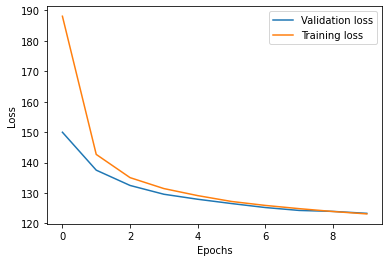

In [ ]:
plt.plot([*range(epochs2)], val_losses, label="Validation loss")
plt.plot([*range(epochs2)], train_losses, label = "Training loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Find expected value in latent space for each number

In [ ]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        # an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img).mean
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

### Plot

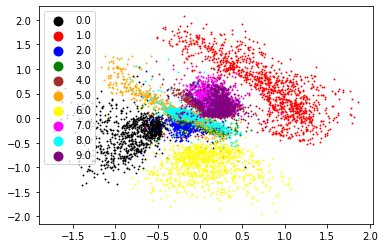

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

In [ ]:
evaluate(model)

tensor(10.1610)

# Bayesian VAE

In [6]:
# Define VAE model
class BVAE(nn.Module):
    def __init__(self, latent_dim):
        super(BVAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, latent_dim) # 20 -> 2
        self.fc22 = nn.Linear(100, latent_dim) # 20 -> 2
        self.fc3 = nn.Linear(latent_dim, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return torch.distributions.normal.Normal(loc = self.fc21(h2), scale = torch.max(torch.exp(0.5*self.fc22(h2)),torch.tensor(1e-4)))

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x): # model(data) = model.forward(data)
        gauss = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        return self.decode(z), gauss.mean, gauss.stddev

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO


def train(epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, model)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    train_losses.append(train_loss / len(train_loader.dataset))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar, model).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [7]:
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
def loss_function(recon_x, x, mu, logvar, model):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD + kl_loss(model)# -ELBO

In [8]:
latent_dim = 2
model = BVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


transform_model(model, nn.Linear, bnn.BayesLinear, 
            args={"prior_mu":0, "prior_sigma":0.1, "in_features" : ".in_features",
                  "out_features" : ".out_features", "bias":".bias"
                 }, 
            attrs={"weight_mu" : ".weight"})

/usr/local/lib/python3.8/dist-packages/torchhk/transform.py:34: Warning: 
 * Caution : The Input Model is CHANGED because inplace=True.
  warnings.warn("\n * Caution : The Input Model is CHANGED because inplace=True.", Warning)


BVAE(
  (fc1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=784, out_features=400, bias=True)
  (fc1a): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=400, out_features=100, bias=True)
  (fc21): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=2, bias=True)
  (fc22): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=2, bias=True)
  (fc3): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=100, bias=True)
  (fc3a): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=400, bias=True)
  (fc4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=400, out_features=784, bias=True)
)

====> Epoch: 1 Average loss: 254.9413
====> Test set loss: 224.4661


<ipython-input-9-3b6262f1e12e>:15: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


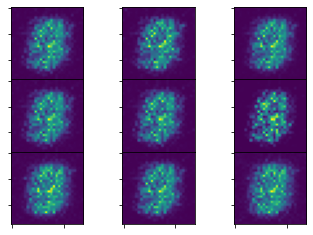

====> Epoch: 2 Average loss: 220.6525
====> Test set loss: 217.5775


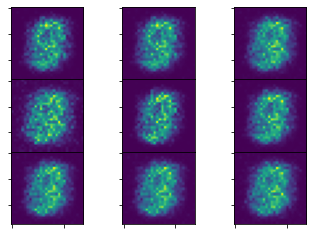

====> Epoch: 3 Average loss: 214.2999
====> Test set loss: 207.1436


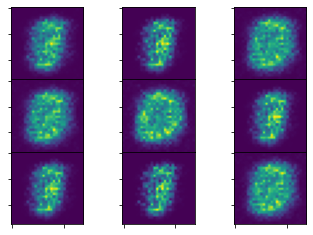

====> Epoch: 4 Average loss: 204.0406
====> Test set loss: 201.4246


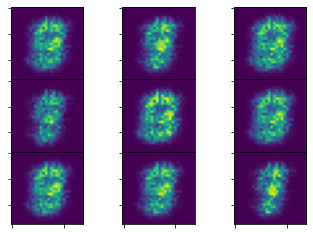

====> Epoch: 5 Average loss: 199.4232
====> Test set loss: 198.3623


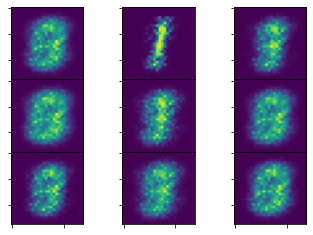

====> Epoch: 6 Average loss: 197.4675
====> Test set loss: 196.9230


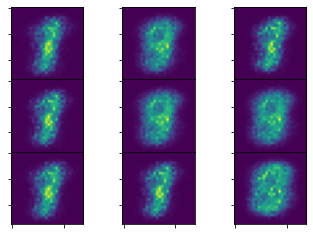

====> Epoch: 7 Average loss: 195.7944
====> Test set loss: 194.4784


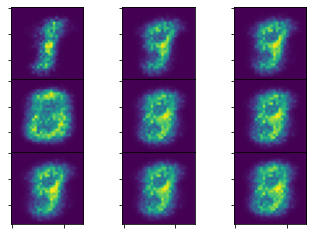

====> Epoch: 8 Average loss: 195.0496
====> Test set loss: 193.3787


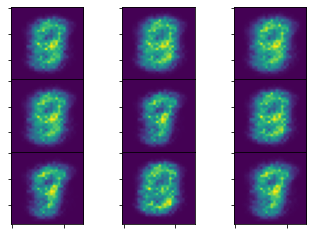

====> Epoch: 9 Average loss: 194.1027
====> Test set loss: 192.9036


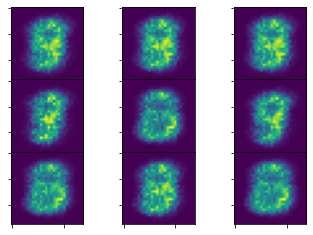

====> Epoch: 10 Average loss: 191.6138
====> Test set loss: 189.3479


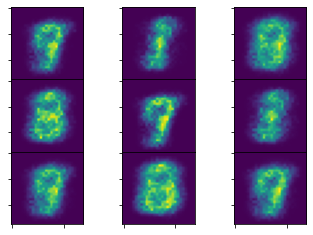

====> Epoch: 11 Average loss: 188.5926
====> Test set loss: 186.7687


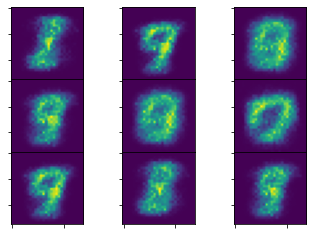

====> Epoch: 12 Average loss: 186.5955
====> Test set loss: 184.5756


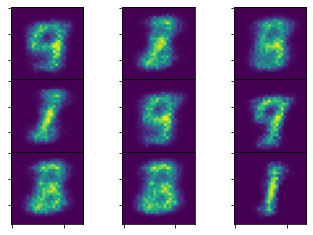

====> Epoch: 13 Average loss: 184.6231
====> Test set loss: 183.4180


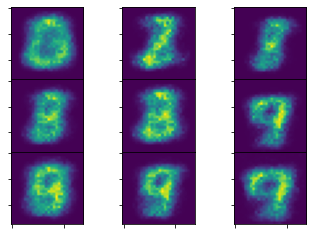

====> Epoch: 14 Average loss: 182.7998
====> Test set loss: 181.9848


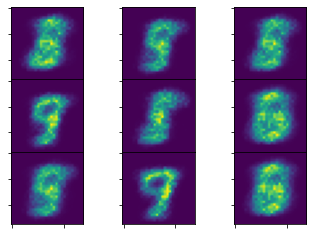

====> Epoch: 15 Average loss: 181.8114
====> Test set loss: 180.6063


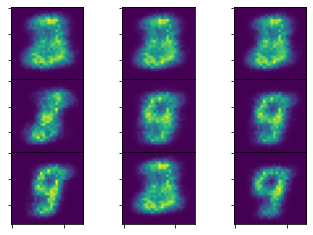

====> Epoch: 16 Average loss: 180.8302
====> Test set loss: 179.8127


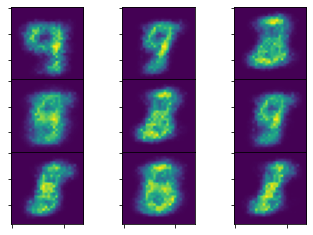

====> Epoch: 17 Average loss: 180.2755
====> Test set loss: 179.3849


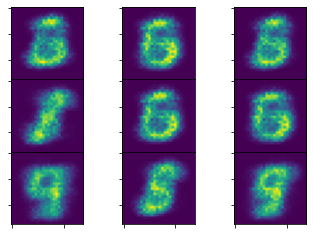

====> Epoch: 18 Average loss: 179.7009
====> Test set loss: 178.7642


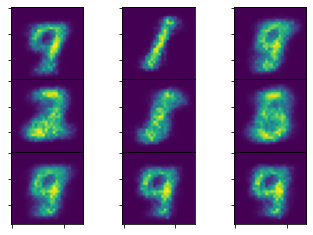

====> Epoch: 19 Average loss: 179.2428
====> Test set loss: 178.7189


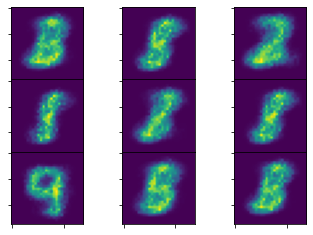

====> Epoch: 20 Average loss: 178.6692
====> Test set loss: 177.8155


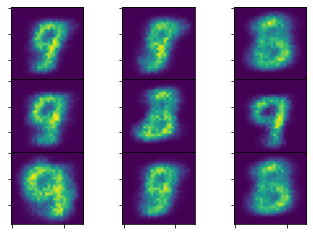

====> Epoch: 21 Average loss: 178.2932
====> Test set loss: 177.7741


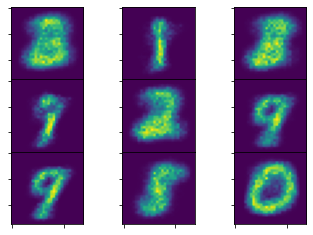

====> Epoch: 22 Average loss: 177.8533
====> Test set loss: 177.3719


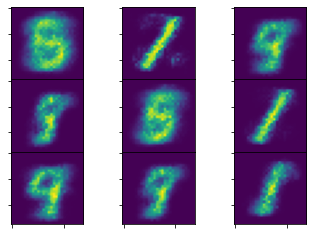

====> Epoch: 23 Average loss: 177.1515
====> Test set loss: 176.8136


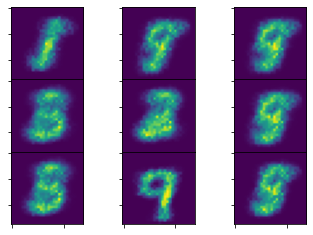

====> Epoch: 24 Average loss: 177.0289
====> Test set loss: 175.9325


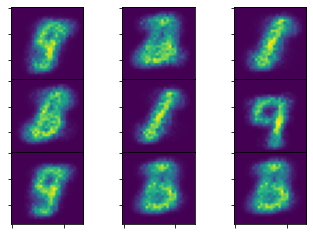

====> Epoch: 25 Average loss: 176.7623
====> Test set loss: 175.7648


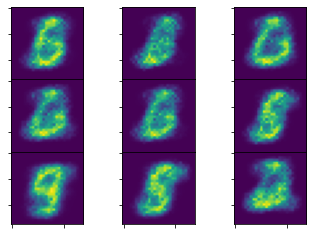

====> Epoch: 26 Average loss: 175.8120
====> Test set loss: 175.2853


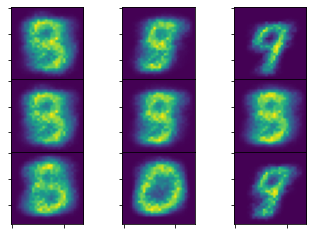

====> Epoch: 27 Average loss: 175.6852
====> Test set loss: 174.9625


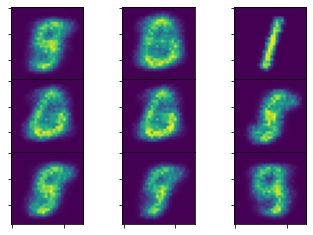

====> Epoch: 28 Average loss: 175.1547
====> Test set loss: 174.8142


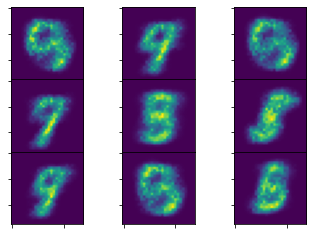

====> Epoch: 29 Average loss: 175.0468
====> Test set loss: 173.7054


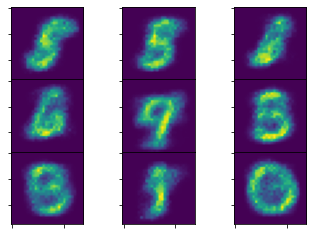

====> Epoch: 30 Average loss: 174.5498
====> Test set loss: 174.1988


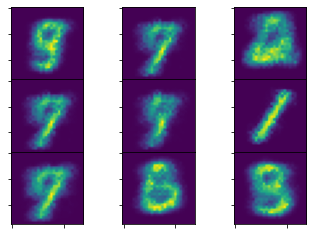

In [9]:
epochs2 = 30 # 10

train_losses = []
val_losses = []
for epoch in range(1, epochs2 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        # save_image(sample.view(64, 1, 28, 28),
        #            'results/sample_' + str(epoch) + '.png')
        # plt.imshow(sample[0].reshape([28,28]))
        fig, ax = plt.subplots(3,3,constrained_layout=True)
        plt.subplots_adjust(wspace=0, hspace=0)
        for i, ax in enumerate(ax.flatten()):
            ax.imshow(sample[i].reshape([28,28]))
            plt.axis('on')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        plt.show()

### Plot orig and reconstructed + samples

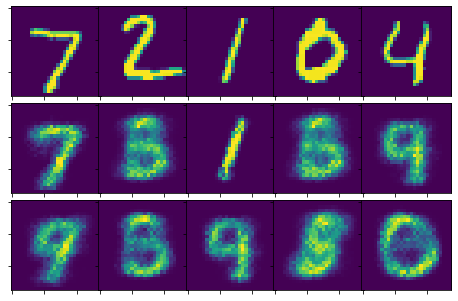

In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    fig, ax = plt.subplots(nrows=3, ncols=5, sharex = True, sharey = True)
    for j in range(5):
      for i in range(2):
          ax[i,j].set_xticklabels([])
          ax[i,j].set_yticklabels([])
    sample = sample_image
    for j in range(5):
      ax[0,j].imshow(sample[j].reshape([28,28]))
    sample = model(sample_image)[0]
    for j in range(5):
      ax[1,j].imshow(sample[j].reshape([28,28]))
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    for j in range(5):
     ax[2,j].imshow(sample[j].reshape([28,28]))
          
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis('on')
plt.show()

### adsf 

<ipython-input-12-b8f7f1a1f3c6>:11: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


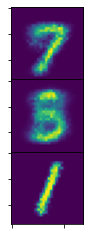

<ipython-input-12-b8f7f1a1f3c6>:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


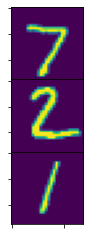

In [12]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=False, **kwargs)
for test_images, test_labels in test_loader:  
    sample_image = test_images    # Reshape them according to your needs.
    break
model.eval()
with torch.no_grad():
    sample = model(sample_image)[0]
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()
    sample =sample_image
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

<ipython-input-130-73106014c787>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(wspace=0, hspace=0)


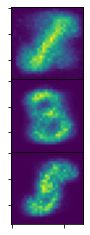

In [130]:
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device) # 20 -> 2
    sample = model.decode(sample).cpu()
    # save_image(sample.view(64, 1, 28, 28),
    #            'results/sample_' + str(epoch) + '.png')
    # plt.imshow(sample[0].reshape([28,28]))
    fig, ax = plt.subplots(3,1,constrained_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, ax in enumerate(ax.flatten()):
        ax.imshow(sample[i].reshape([28,28]))
        plt.axis('on')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.show()

Text(0, 0.5, 'Loss')

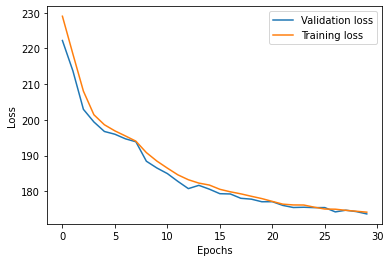

In [124]:
plt.plot([*range(epochs2)], val_losses, label="Validation loss")
plt.plot([*range(epochs2)], train_losses, label = "Training loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")

### Find expected value in latent space for each number

In [1]:
mnist_test = list(test_loader)
B = len(mnist_test)
B = 20
results = torch.zeros((128*B,2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))
    
    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k,:,:,:]
        an_img_flat = torch.flatten(an_img)
        mean_img = model.encode(an_img_flat).mean
        results[l] = mean_img
        l +=1
results = results[:l,:]
all_labels = all_labels[:l]

NameError: ignored

### Plot

In [ ]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

In [13]:
evaluate(model)

tensor(41.3726)

# Mixture model

In [6]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_X = train_X.reshape([60000, 784])
test_X = test_X.reshape([10000, 784])

In [ ]:
from sklearn import mixture
g = mixture.GaussianMixture(n_components=10)
g.fit(train_X[0:20000])

GaussianMixture(n_components=10)

In [ ]:
sample = g.sample(1)

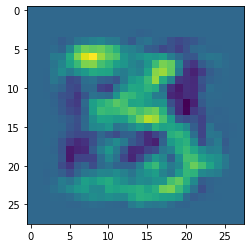

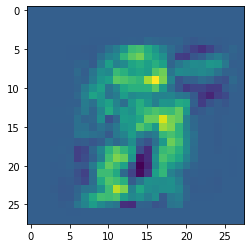

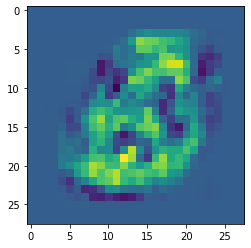

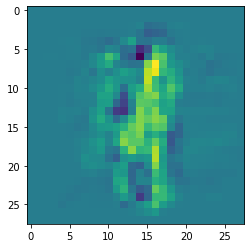

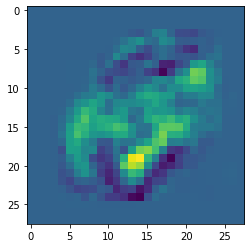

In [ ]:
for i in range(5):
  plt.imshow(g.sample(1)[0].reshape((28,28)))
  plt.show()


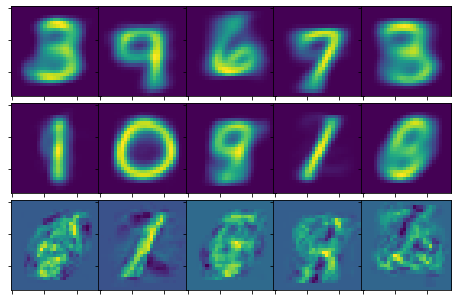

In [ ]:
mmmm = g.means_
fig, ax = plt.subplots(nrows=3, ncols=5, sharex = True, sharey = True)
for i in range(2):
    for j in range(5):
      ax[i,j].imshow(mmmm[i*5 + j, :].reshape((28,28)))
      ax[i,j].set_xticklabels([])
      ax[i,j].set_yticklabels([])
for j in range(5):
  ax[2,j].imshow(g.sample(1)[0].reshape((28,28)))
      
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis('on')
plt.show()

0


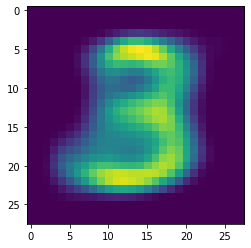

1


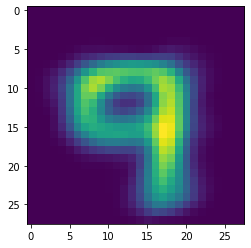

2


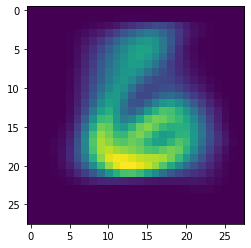

3


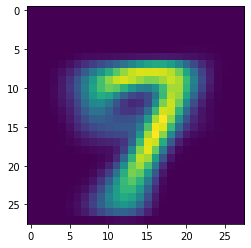

4


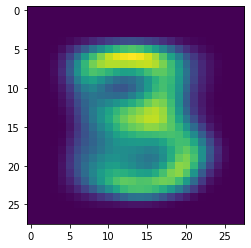

5


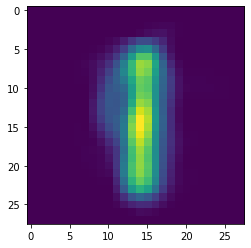

6


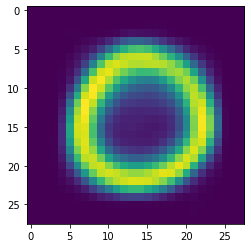

7


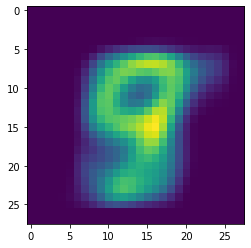

8


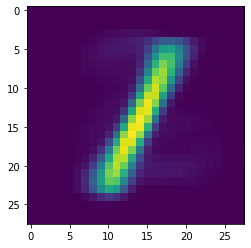

9


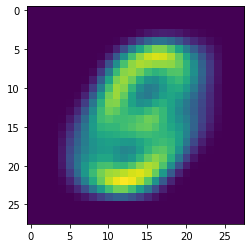

In [ ]:
for i in range(10):
  print(i)
  plt.imshow(mmmm[i, :].reshape((28,28)))
  plt.show()

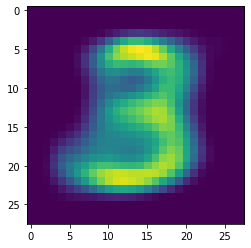

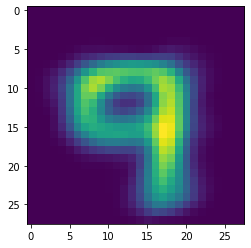

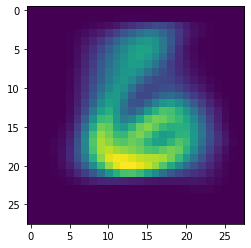

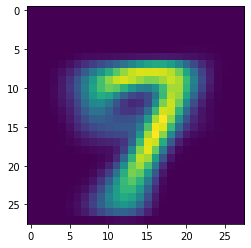

In [ ]:
m_a = mmmm[0, :]
m_b = mmmm[1, :]
m_c = mmmm[2, :]
m_d = mmmm[3, :]
plt.imshow(m_a.reshape((28,28)))
plt.show()
plt.imshow(m_b.reshape((28,28)))
plt.show()
plt.imshow(m_c.reshape((28,28)))
plt.show()
plt.imshow(mmmm[3, :].reshape((28,28)))
plt.show()

# PPCA

In [99]:
data_vec = torch.reshape(torch.tensor(train_X), (60000, 28*28)) # Make into vector
N = 60000
data_cov = torch.cov(data_vec.T)
data_eig = torch.linalg.eig(data_cov)

In [100]:
D = data_eig.eigenvectors.shape[1]
M = 2
sig_sq = 1/(D-M)*torch.sum(data_eig.eigenvalues[2:])

In [101]:
U_M = data_eig.eigenvectors[:,:2]
L_M = torch.diag(data_eig.eigenvalues[:2])

In [102]:
W = torch.matmul(U_M, (L_M-sig_sq*torch.eye(2))**0.5)

In [103]:
data_vec_double = data_vec.type(torch.DoubleTensor)

In [104]:
mu = torch.mean(data_vec_double, 0)

In [105]:
M = torch.matmul(W.T, W) + sig_sq * torch.eye(2)

In [106]:
x_mu = data_vec_double.T - mu.repeat(N,1).T

In [107]:
temp = torch.inverse(M)@W.T

In [108]:
# x_mu_complex = x_mu.type(torch.complex64)
temp_double = temp.type(torch.double)

In [109]:
z_values = temp_double@x_mu

In [110]:
z_values.shape

torch.Size([2, 60000])

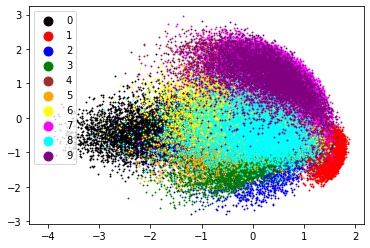

In [111]:
results_for_plot = z_values.detach().numpy().T

scatter_x = results_for_plot[:,0]
scatter_y = results_for_plot[:,1]
group = train_y

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 0.8)
ax.legend(markerscale = 10)
plt.show()

In [112]:
loss = 0
for i in range(60000):
  rec = W.numpy() @ z_values[:,i].numpy() + mu.numpy()
  loss =+ np.sum(np.square(rec.real.reshape([28,28]) - data_vec[i].reshape([28,28]).numpy()))

loss = loss/60000
loss




47.90285757776857

In [ ]:
plt.imshow(data_vec[3].reshape([28,28]))
plt.show()
rec = W.numpy() @ z_values[:,3].numpy() + mu.numpy()
plt.imshow(rec.real.reshape([28,28]))
plt.show()

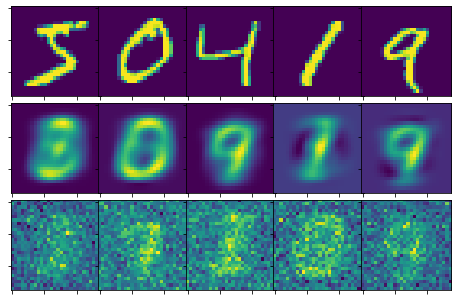

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=5, sharex = True, sharey = True)

for j in range(5):
  for i in range(2):
      ax[i,j].set_xticklabels([])
      ax[i,j].set_yticklabels([])

for j in range(5):
  ax[0,j].imshow(data_vec[j].reshape([28,28]))
for j in range(5):
  rec = W.numpy() @ z_values[:,j].numpy() + mu.numpy()
  ax[1,j].imshow(rec.real.reshape([28,28]))
for j in range(5):
  sample_z = torch.randn(1, 2)
  sample = W.numpy().real @ sample_z.numpy().reshape([2,1]) + mu.numpy().reshape([784,1]) + torch.sqrt(sig_sq).numpy().real * torch.randn(784,1).numpy()
  ax[2,j].imshow(sample.reshape([28,28]))
      
slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.axis('on')
plt.show()

In [33]:
sample_z = torch.randn(1, 2)

In [34]:
sample = W.numpy().real @ sample_z.numpy().reshape([2,1]) + mu.numpy().reshape([784,1]) + torch.sqrt(sig_sq).numpy().real * torch.randn(784,1).numpy()

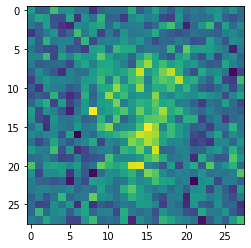

In [35]:
plt.imshow(sample.reshape([28,28]))
plt.show()